In [ ]:
pip install pybbn
pip install matplotlib

# Solution Template

Use this notebook as a guide to implement your solution. Keep in mind that some cells should remain as they are so that you code works properly, for instance, the following cell in which the required libraries are imported.

In [28]:
import pandas as pd
import numpy as np
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
from pybbn.graph.dag import Bbn # for creating Bayesian Belief Networks (BBN)
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

Just run the next cell to load the data.

In [29]:
diabetes = pd.read_csv('https://raw.githubusercontent.com/danotero/MA2014/main/M%C3%B3dulo%20II/diabetes-dataset.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


Create a new column called `Overweight` in which a person whose `BMI` is above 25 will be tagged as a one, and zero otherwise.

In [30]:
def asignar_valor(valor):
    if valor < 25:
        return 0
    else:
        return 1

diabetes['Overweight'] = diabetes['BMI'].apply(asignar_valor)

You are to code the next function, which discretize all the variables of the dataset, except `Outcome` and `Overweight`. Remember that you will discretize with respect to the quantiles of each variables: if a variable value is less than Q1, then said value is replaced by a **zero**; if the given value is greater or equal than Q1 but less than Q2, then the value should be replaced by a **one**; if the variable value is greater or equal than Q2 but less than Q3, then the value should be replaced by a **two**; finally, if a variable value is greater than Q3, it should be assigned the value **three**. 

In [31]:
def discretize(df):
    quantiles = df.quantile([0.25, 0.5, 0.75])
    for column in df.columns:
        if column not in ['Outcome', 'Overweight']:
            q1 = quantiles[column][0.25]
            q2 = quantiles[column][0.5]
            q3 = quantiles[column][0.75]

            df[column] = df[column].apply(lambda x: 0 if x < q1 else (1 if q1 <= x < q2 else (2 if q2 <= x < q3 else 3)))

    return df

In [36]:
discrete_df=discretize(diabetes)
discrete_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Overweight
0,1,2,0,3,1,2,0,3,1,1
1,0,0,3,2,2,3,0,0,0,1
2,0,3,0,1,1,3,3,2,1,1
3,0,2,1,3,3,3,1,1,1,1
4,1,2,0,3,3,3,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1995,1,0,1,2,2,1,1,2,0,1
1996,3,3,2,3,3,2,3,2,1,1
1997,3,0,2,1,1,1,2,3,0,1
1998,0,2,3,3,3,3,1,1,1,1


In [38]:
new_data = {
    'Pregnancies': [0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,3,3,3,3,3,3],
    'Glucose': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    'BloodPressure': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    'SkinThickness': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    'Insulin': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    'BMI': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    'DiabetesPedigreeFunction': [0,3,0,1,2,2,0,2,0,1,0,1,0,3,0,2,0,0,1,2,2,3,3,2,3,1],
    'Age': [1,1,2,2,2,2,3,3,2,2,3,3,1,1,3,3,0,0,0,0,0,0,0,1,1,3],
    'Outcome': [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0],
    'Overweight': [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0]
}

new_rows = pd.DataFrame(new_data)
discrete_df=pd.concat([discrete_df, new_rows], ignore_index=True)
discrete_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Overweight
0,1,2,0,3,1,2,0,3,1,1
1,0,0,3,2,2,3,0,0,0,1
2,0,3,0,1,1,3,3,2,1,1
3,0,2,1,3,3,3,1,1,1,1
4,1,2,0,3,3,3,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2021,3,0,0,0,0,0,3,0,0,0
2022,3,0,0,0,0,0,3,0,1,1
2023,3,0,0,0,0,0,2,1,0,0
2024,3,0,0,0,0,0,3,1,0,0


In the following cel you are to create two dictionaries: `graph` will store the topology of the Bayesian network, so each element is associated to a list that contains the names of the parents of said element; `values` stores the values that each variable of the network takes, which are the discrete values that were computed above.

In [39]:
graph = {'Overweight': [],
         'DiabetesPedigreeFunction': [],
         'Age': [],
         'Pregnancies': [],
         'SkinThickness' : ['Overweight'],
         'BMI': ['Overweight'],
         'Outcome': ['Age','Pregnancies','Overweight','DiabetesPedigreeFunction'],
         'BloodPressure': ['Outcome','Overweight'],
         'Insulin': ['Outcome'],
         'Glucose': ['Outcome']}

values = {'Overweight': [0,1],
          'DiabetesPedigreeFunction': [0,1,2,3],
          'Age': [0,1,2,3],
          'Pregnancies': [0,1,2,3],
          'SkinThickness' : [1,2,3],
          'BMI': [0,1,2,3],
          'Outcome': [0,1],
          'BloodPressure': [0,1,2,3],
          'Insulin': [1,2,3],
          'Glucose': [0,1,2,3]}

The next function obtains the probabilities of a given node. This function will be used later to create a dictionary in which each element contains a node and its list of probabilities.

In [44]:
def probs(data, child, graph):
    num_par = len(graph[child])
    if num_par == 0:
        # Calculate probabilities
        prob = pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif num_par == 1:
        # Calculate probabilities for one parent
        prob = pd.crosstab(data[graph[child][0]], data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    elif num_par == 2:
        # Calculate probabilities for two parents
        prob = pd.crosstab([data[graph[child][0]], data[graph[child][1]]], data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    elif num_par == 3:
        # Calculate probabilities for three parents
        prob = pd.crosstab([data[graph[child][0]], data[graph[child][1]], data[graph[child][2]]], data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    elif num_par == 4:
        # Calculate probabilities for four parents
        prob = pd.crosstab([data[graph[child][0]], data[graph[child][1]], data[graph[child][2]], data[graph[child][3]]], data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else:
        print("Error in Probability Frequency Calculations")
        prob = None  # You might want to assign a default value here
    return prob

Create the nodes of the network in this cell. For each line, replace `"node index"` and the empty list by the proper variable name and variable values, respectively.

In [45]:
overweight_probabilities=probs(discrete_df, child='Overweight', graph=graph)
overweight = BbnNode(Variable(0, 'Overweight', values['Overweight']), overweight_probabilities)

diabetes_pedigree_function_probabilities=probs(discrete_df, child='DiabetesPedigreeFunction', graph=graph)
diabetes_pedigree_function = BbnNode(Variable(3, 'DiabetesPedigreeFunction', values['DiabetesPedigreeFunction']), diabetes_pedigree_function_probabilities)

age_probabilities=probs(discrete_df, child='Age', graph=graph)
age = BbnNode(Variable(4, 'Age', values['Age']), age_probabilities)

pregnancies_probabilities=probs(discrete_df, child='Pregnancies', graph=graph)
pregnancies = BbnNode(Variable(5, 'Pregnancies', values['Pregnancies']), pregnancies_probabilities)

skin_thickness_probabilities=probs(discrete_df, child='SkinThickness', graph=graph)
skin_thickness = BbnNode(Variable(1, 'SkinThickness', values['SkinThickness']), skin_thickness_probabilities)

bmi_probabilities=probs(discrete_df, child='BMI', graph=graph)
bmi = BbnNode(Variable(2, 'BMI', values['BMI']), bmi_probabilities)

outcome_probabilities=probs(discrete_df, child='Outcome', graph=graph)
outcome = BbnNode(Variable(6, 'Outcome', values['Outcome']), outcome_probabilities)

blood_pressure_probabilities=probs(discrete_df, child='BloodPressure', graph=graph)
blood_pressure = BbnNode(Variable(9, 'BloodPressure', values['BloodPressure']), blood_pressure_probabilities)

insulin_probabilities=probs(discrete_df, child='Insulin', graph=graph)
insulin = BbnNode(Variable(7, 'Insulin', values['Insulin']), insulin_probabilities)

glucose_probabilities=probs(discrete_df, child='Glucose', graph=graph)
glucose = BbnNode(Variable(8, 'Glucose', values['Glucose']), glucose_probabilities)



Implement your graph in the following cell. Add as many nodes and edges as necessary. Replace the strings by the proper variables.

In [46]:
bbn = Bbn() \
    .add_node(overweight) \
    .add_node(diabetes_pedigree_function) \
    .add_node(age) \
    .add_node(pregnancies) \
    .add_node(skin_thickness) \
    .add_node(bmi) \
    .add_node(outcome) \
    .add_node(blood_pressure) \
    .add_node(insulin) \
    .add_node(glucose)\
    .add_edge(Edge(age, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(diabetes_pedigree_function, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, outcome, EdgeType.DIRECTED))\
    .add_edge(Edge(pregnancies, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, blood_pressure, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, glucose, EdgeType.DIRECTED))\
    .add_edge(Edge(outcome, insulin, EdgeType.DIRECTED))\
    .add_edge(Edge(overweight, blood_pressure, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, bmi, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, skin_thickness, EdgeType.DIRECTED)) \



Do not forget to run this cell and do not modify it, inferences depend on it.

In [47]:
# Convert the BBN to a join tree. Do not modify this cell.

join_tree = InferenceController.apply(bbn)

The following cell is very useful for visualizing your Bayesian network. It is very recommended that you make the necessary changes and run it to verify that your network was implementented correctly.

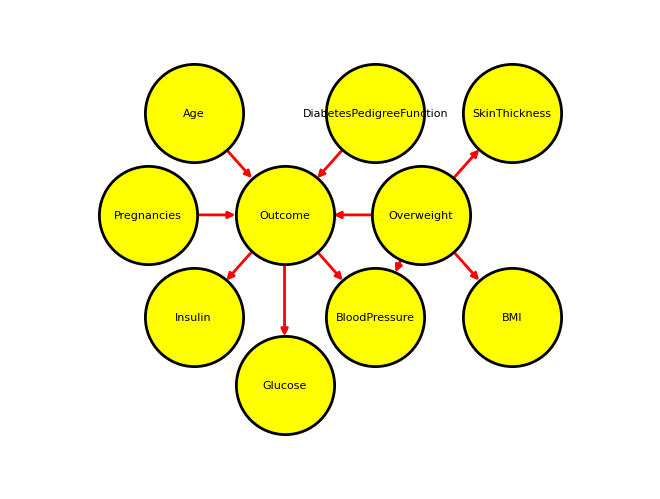

In [49]:
# Set node positions.

pos = {
    0: (300, 0),  
    1: (500, 300),
    2: (500,-300),
    3: (200,300),
    4: (-200,300),
    5: (-300,0),
    6: (0,0),
    7: (-200,-300),
    8: (0,-500),
    9: (200,-300)
   
}

# Set options for graph looks. You might have to adjust these parameters.

options = {"font_size" : 8, "node_size" : 5000, "node_color" : "yellow",
           "edgecolors" : "black", "edge_color" : "red", "linewidths" : 2,
           "width": 2}

# Generate graph.

n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph.

ax = plt.gca()
ax.margins(0.3)
plt.axis("off")
plt.show()

The goal of `print_probs` is to print out the probability distributions of all the nodes of the network. You can modify this code to print only the distributions of certain nodes if you find that helpful.

In [50]:
# Define a function for printing marginal probabilities.
nodes=[overweight,diabetes_pedigree_function,age,pregnancies,skin_thickness,bmi,outcome,blood_pressure,insulin,glucose]
nodes2=['overweight','diabetes_pedigree_function','age','pregnancies','skin_thickness','bmi','outcome','blood_pressure','insulin','glucose']

def print_probs():
    for i in range(len(nodes)):
        node=nodes[i]
        potential = join_tree.get_bbn_potential(node)
        
        print("Node:", nodes2[i])
        print("Values:")
        print(potential)
        print('----------------')

# Use the above function to print marginal probabilities.

print_probs()

Node: overweight
Values:
0=0|0.29501
0=1|0.70499
----------------
Node: diabetes_pedigree_function
Values:
3=0|0.24806
3=1|0.25260
3=2|0.24990
3=3|0.24944
----------------
Node: age
Values:
4=0|0.23189
4=1|0.26374
4=2|0.24456
4=3|0.25981
----------------
Node: pregnancies
Values:
5=0|0.15383
5=1|0.31873
5=2|0.26192
5=3|0.26552
----------------
Node: skin_thickness
Values:
1=1|0.07171
1=2|0.25617
1=3|0.67212
----------------
Node: bmi
Values:
2=0|0.38195
2=1|0.20519
2=2|0.20602
2=3|0.20684
----------------
Node: outcome
Values:
6=0|0.69338
6=1|0.30662
----------------
Node: blood_pressure
Values:
9=0|0.29454
9=1|0.23066
9=2|0.23747
9=3|0.23732
----------------
Node: insulin
Values:
7=1|0.09767
7=2|0.41683
7=3|0.48549
----------------
Node: glucose
Values:
8=0|0.25415
8=1|0.25676
8=2|0.25058
8=3|0.23852
----------------


The function `evidence` helps tyou to create evidence that will be used for making inferences. Do not modify this cell, please.

In [51]:
# To add evidence of events that happened so probability distribution can be recalculated.

def evidence(ev, nod, val, like):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(val, like) \
    .build()
    join_tree.set_observation(ev)

Now you are ready to add evidence and print out the new distributions of your network. 

In [54]:
evidence('ev1', 'Age', 3, 1)
evidence('ev1', 'Overweight', 1, 1)
print_probs()

Node: overweight
Values:
0=0|0.00000
0=1|1.00000
----------------
Node: diabetes_pedigree_function
Values:
3=0|0.24853
3=1|0.24967
3=2|0.25130
3=3|0.25050
----------------
Node: age
Values:
4=0|0.00000
4=1|0.00000
4=2|0.00000
4=3|1.00000
----------------
Node: pregnancies
Values:
5=0|0.15508
5=1|0.31785
5=2|0.25775
5=3|0.26932
----------------
Node: skin_thickness
Values:
1=1|0.07153
1=2|0.00527
1=3|0.92320
----------------
Node: bmi
Values:
2=0|0.12332
2=1|0.29106
2=2|0.29223
2=3|0.29340
----------------
Node: outcome
Values:
6=0|0.43334
6=1|0.56666
----------------
Node: blood_pressure
Values:
9=0|0.20604
9=1|0.23630
9=2|0.25814
9=3|0.29953
----------------
Node: insulin
Values:
7=1|0.16317
7=2|0.26354
7=3|0.57329
----------------
Node: glucose
Values:
8=0|0.18445
8=1|0.22097
8=2|0.25963
8=3|0.33494
----------------


If you need to reset the Bayesian network, rerun this line of code or rerun the above cell twice.

In [53]:
join_tree = InferenceController.apply(bbn)